<a href="https://colab.research.google.com/github/ZawWin58/firstproject/blob/master/lab6-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import numpy as np
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:

def generate_x_y_data_two_freqs(isTrain , batch_size , seq_length):
    batch_x = [] 
    batch_y = []

    for _ in range(batch_size):
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() + 0.1
        
        sig1 = amp_rand * np.sin(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand , seq_length * 2)
        )
        
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() * 1.2
        sig1 = amp_rand * np.cos(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand , seq_length * 2)
        ) + sig1
        
        x1 = sig1[:seq_length]
        y1 = sig1[seq_length:]
        x_ = np.array([x1])
        y_ = np.array([y1])
        x_, y_ = x_.T, y_.T
        
        batch_x.append(x_)
        batch_y.append(y_)
        
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    # размерность: (batch_size , seq_length , output_dim)
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2))
    # размерность: (seq_length , batch_size , output_dim)

    return batch_x , batch_y

In [0]:
def generate_x_y_data_v3(isTrain , batch_size): 
  seq_length = 30 
  x, y = generate_x_y_data_two_freqs( isTrain , batch_size , seq_length=seq_length) 
  noise_amount = random.random() * 0.15 + 0.10
  x = x + noise_amount * np.random.randn(seq_length , batch_size , 1)
  avg = np.average(x) 
  std = np.std(x) + 0.0001
  x = x - avg 
  y = y - avg 
  x = x / std / 2.5 
  y = y / std / 2.5

  return x, y

In [0]:
def generate_x_y_data(isTrain, batch_size):
    return generate_x_y_data_v3(isTrain, batch_size)

In [0]:
# Данные имеют размерность (seq_length , batch_size , output_dim) 
sample_x , sample_y = generate_x_y_data(isTrain=True , batch_size=3)

# Длина последовательности (в данных примерах одинаковая для обучающих и тестовых данных)
seq_length = sample_x.shape[0] 

# Размер пакета количество(тестовых примеров), по которому усредняется градиент
batch_size = 100
# Размерность выходных данных 
output_dim = input_dim = sample_x.shape[-1]
# Количество скрытых нейронов в каждой ячейке
hidden_dim = 50
# Количество ячеек рекуррентной сети (в глубину)
layers_stacked_count = 1

# Параметры оптимизатора 
# Скорость обучения маленькая (скорость обучения позволяет алгоритму не расходиться во время обучения)
learning_rate = 0.5
# Количество итераций по обучающей выборке 
nb_iters = 5000
# Дополнительные параметры алгоритма оптимизации
lr_decay = 0.3
momentum = 0.9
# Коэффициент L2 регуляризации
lambda_l2_reg = 1e-10

In [7]:
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.reset_default_graph()
# интерактивная сессия
sess = tf.InteractiveSession()

In [9]:
with tf.variable_scope('Seq2seq'):
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
            for t in range(seq_length)
    ]

    expected_sparse_output = [
        tf.placeholder(tf.float32 , shape=(None , output_dim), name="expected_sparse_output_".format(t))
            for t in range(seq_length)
    ]
    
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32 , name="GO") ] + enc_inp[:-1]
    
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    w_in = tf.Variable(tf.random_normal([input_dim , hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim], mean=1.0))
    w_out = tf.Variable(tf.random_normal([hidden_dim , output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))

    reshaped_inputs = [tf.nn.relu(tf.matmul(i, w_in) + b_in) for i in enc_inp]
    
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(enc_inp, dec_inp, cell)
    
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    reshaped_outputs = [output_scale_factor * (tf.matmul(i, w_out) + b_out) for i in dec_outputs]

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))

    # слагаемое, отвечающее за L2 регуляризацию
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

    loss = output_loss  + lambda_l2_reg * reg_loss

In [11]:
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:

# Шаг обучения, который оптимизирует веса в соответствии с переданным минипакетом-примеров
def train_batch(batch_size):
    X, Y = generate_x_y_data(isTrain=True , batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))} 
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))}) 
    #  запускаем сессию. При этом рассчитываются тензоры, указанные в первом параметре, 
    # а значения для них берутся из второго параметра
    _, loss_t = sess.run([train_op , loss], feed_dict)
    
    return loss_t

In [13]:
# Тестовый прогон. Веса не обновляются благодаря тому, что переменная train_op не передается в sess.run
def test_batch(batch_size, graph=False): 
    X, Y = generate_x_y_data(isTrain=False, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))}) 
    loss_t = sess.run([loss], feed_dict)
    
    return loss_t[0]

train_losses = []
test_losses = []
sess.run(tf.global_variables_initializer())

#nb_iters - количество шагов для обучения. После каждых 10 шагов проверяется ошибка на тестовой выборке

for t in range(nb_iters+1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)

    if t % 10 == 0:
        test_loss = test_batch(batch_size, t==nb_iters)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters , train_loss , test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss , test_loss))

Step 0/5000, train loss: 1838.548583984375, 	TEST loss: 79537.15625
Step 10/5000, train loss: 168694.734375, 	TEST loss: 51309.859375
Step 20/5000, train loss: 25759.052734375, 	TEST loss: 275429.28125
Step 30/5000, train loss: 77175.15625, 	TEST loss: 315.6009826660156
Step 40/5000, train loss: 2616.213623046875, 	TEST loss: 7842.8125
Step 50/5000, train loss: 2040.093017578125, 	TEST loss: 10780.40234375
Step 60/5000, train loss: 1871.6297607421875, 	TEST loss: 19189.83203125
Step 70/5000, train loss: 6992.49658203125, 	TEST loss: 1378.05810546875
Step 80/5000, train loss: 225707.1875, 	TEST loss: 28346.130859375
Step 90/5000, train loss: 2553.650634765625, 	TEST loss: 42796.68359375
Step 100/5000, train loss: 3076.091552734375, 	TEST loss: 14508.498046875
Step 110/5000, train loss: 110968.5390625, 	TEST loss: 9560.2900390625
Step 120/5000, train loss: 8037.69189453125, 	TEST loss: 15043.390625
Step 130/5000, train loss: 95576.7265625, 	TEST loss: 2918.45654296875
Step 140/5000, trai

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location '3'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


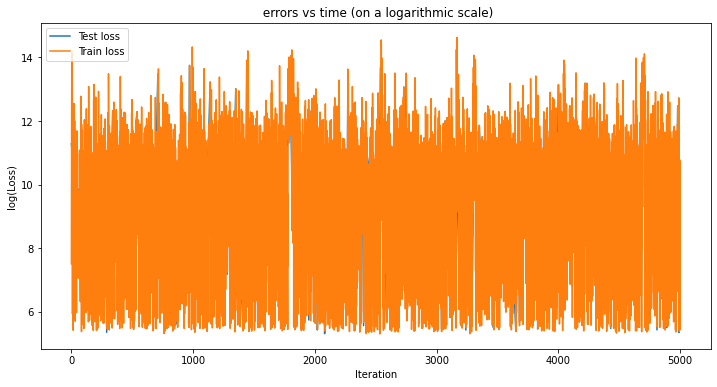

In [14]:
plt.figure(figsize=(12, 6))
plt.plot( np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), np.log(test_losses), label="Test loss")
plt.plot(np.log(train_losses), label="Train loss")

plt.title(" errors vs time (on a logarithmic scale)") 
plt.xlabel('Iteration')
plt.ylabel('log(Loss)') 
plt.legend(loc='3') 
plt.show()

 Let 's visualize 1 predictions with our signals :


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Unrecognized location 'best '. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


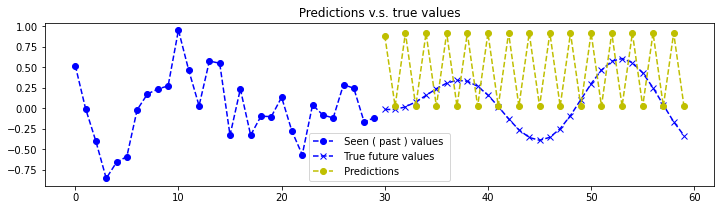

In [15]:

nb_predictions = 1
print (" Let 's visualize {} predictions with our signals :". format (nb_predictions ))
X, Y = generate_x_y_data( isTrain =False , batch_size = nb_predictions )
feed_dict = { enc_inp [t]: X[t] for t in range ( seq_length )}
outputs = np.array( sess.run([ reshaped_outputs ], feed_dict )[0])
# выводим предсказания по каждому пакету
for j in range ( nb_predictions ):
    plt.figure( figsize =(12 , 3))
    for k in range ( output_dim ):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs [:,j,k]
    label1 = " Seen ( past ) values " if k ==0 else " _nolegend_ "
    label2 = " True future values " if k ==0 else " _nolegend_ "
    label3 = " Predictions " if k ==0 else " _nolegend_ "
    plt.plot(range(len(past)), past , "o--b", label = label1 )
    plt.plot(range(len(past),len(expected)+len(past)), expected, "x--b", label = label2)
    plt.plot(range(len(past),len(pred) + len (past)), pred , "o--y", label = label3 )
    plt.legend( loc ='best ')
    plt.title(" Predictions v.s. true values ")
    plt.show()